## Conducting an Analysis of the economic effects of warehouse

Often, proponents of warehouses have always touted the economic benefits it brings to communities. Using the warehouse data set we use previously along with block group data from the ACS 5year for 2019 and 2010, we can seek to the investigate their true effects. Here is a source for the [2019](https://data.census.gov/table?q=Ontario+city,+California&tid=ACSST5Y2019.S0501) and [2010](https://data.census.gov/table?q=Ontario+city,+California&tid=ACSST5Y2010.S0501) data

In [1]:
#importing the neccesary libraries
!pip install pointpats

from pointpats import centrography
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium 
import matplotlib.pyplot as mplt
import contextily as ctx
from shapely import wkt
from shapely.wkt import loads
import plotly.express as px
import osmnx as ox
import numpy as np
from matplotlib.patches import Ellipse
#import centragraphy analysis functions
from pointpats.centrography import hull, mbr, mean_center, weighted_mean_center, manhattan_median, std_distance,euclidean_median,ellipse


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
#import data sets
Ontario_boundary = gpd.read_file('../Data/Ontario Boundary/Ontario Boundary.shp')

SB_County_Block_Group_Employment = pd.read_csv('../Data/SB_County_Block_Group_Employment_2010_2019.csv')
SB_County_Block_Group_Employment = gpd.GeoDataFrame(
    SB_County_Block_Group_Employment.loc[:, [c for c in SB_County_Block_Group_Employment.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(SB_County_Block_Group_Employment["geometry"]),
    crs="epsg:4326")
Warehouse_Parcel_Geo =gpd.read_file('../Data/warehousemaps.geojson')

Warehouse_Parcel_Geo = Warehouse_Parcel_Geo.to_crs(epsg=4326)
Ontario_boundary = Ontario_boundary.to_crs(epsg=4326)
Ontario_boundary=Ontario_boundary.loc[Ontario_boundary['CITY'] == 'Ontario']

SB_County_Block_Group_Employment.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1060 entries, 0 to 1059
Data columns (total 30 columns):
 #   Column                                                              Non-Null Count  Dtype   
---  ------                                                              --------------  -----   
 0   Unnamed: 0                                                          1060 non-null   int64   
 1   STATEFP                                                             1060 non-null   int64   
 2   COUNTYFP                                                            1060 non-null   int64   
 3   TRACTCE                                                             1060 non-null   int64   
 4   BLKGRPCE                                                            1060 non-null   int64   
 5   GEOID                                                               1060 non-null   int64   
 6   NAMELSAD                                                            1060 non-null   object  
 7 

In [3]:
#get limits of ontario city
xylim = Ontario_boundary.geometry.total_bounds
xlim = ([xylim[0],  xylim[2]])
ylim = ([xylim[1],  xylim[3]])

In [4]:
#Keep only warehouses built between 
Warehouse_Parcel_Geo1 = Warehouse_Parcel_Geo[(Warehouse_Parcel_Geo['Year built'] >= 2010) & (Warehouse_Parcel_Geo['Year built'] <= 2019)]
#Have only tracts within ontario
Ontario_boundary_check = Ontario_boundary.geometry.unary_union
SB_County_Block_Group_Employment = SB_County_Block_Group_Employment[SB_County_Block_Group_Employment.geometry.centroid.within(Ontario_boundary_check)]

/tmp/ipykernel_1333/1028596263.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  SB_County_Block_Group_Employment = SB_County_Block_Group_Employment[SB_County_Block_Group_Employment.geometry.centroid.within(Ontario_boundary_check)]


## Change In Warehouse Employment

While the ACS 5 year does not collect warehouse specfic job counts on the block group level, we can use "Transportation and Material Moving Occupations" as a proxy for warehouse and its related jobs. We compare data from 2010 to 2019 for two reasons. Firstly, during this period the shapes of the block groups do not change allowing us to create a better 1 to 1 analysis. Additionally, there was a large growth in warehouses starting in 2011 as part of the bounce back from '08 recession. 

/tmp/ipykernel_1333/1673370868.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Warehouse_Parcel_Geo1.centroid.plot(ax=ax, color='orange',markersize=10,edgecolor="black");


(33.97530509018128, 34.09325978152058)

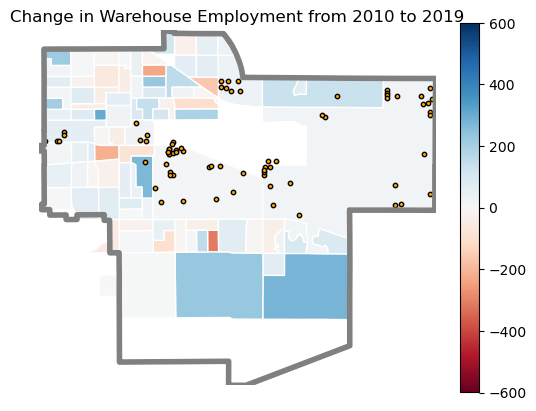

In [5]:
#plot
# Loop the variables
variable = 'Change in Warehouse Employment from 2010 to 2019'
ax = SB_County_Block_Group_Employment.plot(column=variable, cmap='RdBu', edgecolor="white", legend=True, vmax=600, vmin=-600)
Warehouse_Parcel_Geo1.centroid.plot(ax=ax, color='orange',markersize=10,edgecolor="black");
Ontario_boundary.plot(ax=ax, facecolor="none", edgecolor="grey", lw=4)
ax.set_title(variable)
ax.set_axis_off()
#ctx.add_basemap(ax, crs=4326);
ax.set_xlim(xlim)
ax.set_ylim(ylim)

/tmp/ipykernel_1333/2318185468.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Warehouse_Parcel_Geo1.centroid.plot(ax=ax, color='orange',markersize=10,edgecolor="black");


(33.97530509018128, 34.09325978152058)

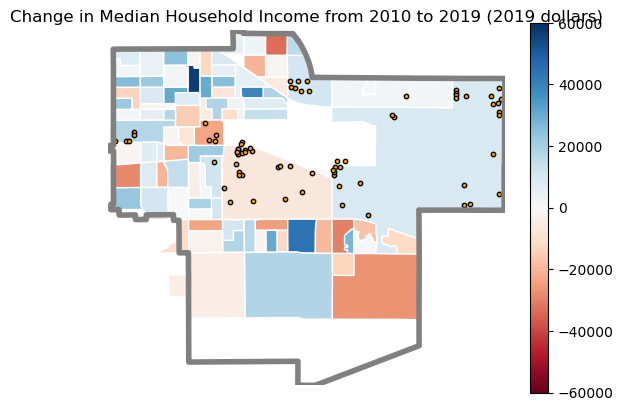

In [6]:
#plot
variable = 'Change in Median Household Income from 2010 to 2019 (2019 dollars)'
ax = SB_County_Block_Group_Employment.plot(column=variable,  cmap='RdBu', edgecolor="white", legend=True, vmax=60000, vmin=-60000)
Warehouse_Parcel_Geo1.centroid.plot(ax=ax, color='orange',markersize=10,edgecolor="black");
Ontario_boundary.plot(ax=ax, facecolor="none", edgecolor="grey", lw=4)
ax.set_title(variable)
ax.set_axis_off()
#ctx.add_basemap(ax, crs=4326);
ax.set_xlim(xlim)
ax.set_ylim(ylim)

## 

In [7]:
#finding the weighted mean for population in ontario
SB_County_Block_Group_Employment["x"] = SB_County_Block_Group_Employment.geometry.centroid.x
SB_County_Block_Group_Employment["y"] = SB_County_Block_Group_Employment.geometry.centroid.y
Warehouse_Parcel_Geo["x"] = Warehouse_Parcel_Geo.geometry.centroid.x
Warehouse_Parcel_Geo["y"] = Warehouse_Parcel_Geo.geometry.centroid.y


SB_County_Block_Group_Employment['centroid'] = SB_County_Block_Group_Employment.geometry.centroid
pip_mask = SB_County_Block_Group_Employment.within(Ontario_boundary['geometry'])

BGwmc = weighted_mean_center(SB_County_Block_Group_Employment[['x','y']], SB_County_Block_Group_Employment['Total Population 2019']) 

Warehouse_Mean_Center = centrography.mean_center(Warehouse_Parcel_Geo[['x','y']])
WH_major, WH_minor, WH_rotation = centrography.ellipse(Warehouse_Parcel_Geo[['x','y']])

# Construct the standard ellipse using matplotlib
#stdellipse = Ellipse(xy=mean_center, 
  #                width=WH_major*2, 
   #               height=WH_minor*2, 
    #              angle = np.rad2deg(WH_rotation))

/tmp/ipykernel_1333/3793054086.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  SB_County_Block_Group_Employment["x"] = SB_County_Block_Group_Employment.geometry.centroid.x
/tmp/ipykernel_1333/3793054086.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  SB_County_Block_Group_Employment["y"] = SB_County_Block_Group_Employment.geometry.centroid.y
/tmp/ipykernel_1333/3793054086.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Warehouse_Parcel_Geo["x"] = Warehouse_Parcel_Geo.geometry.centroid.x
/tmp/ipykernel_1333/3793054086.py:5: UserWarning: Geometry is in a geogra

In [8]:
# Make the mean centers into geodataframes for plotting
BGwmc_df = pd.DataFrame(np.array([['Weight Mean Population Center', BGwmc[0], BGwmc[1]]]),
                   columns=['Label', 'lat', 'long'])
Warehouse_df = pd.DataFrame(np.array([['Mean Warehouse Center', Warehouse_Mean_Center[0], Warehouse_Mean_Center[1]]]),
                   columns=['Label', 'lat', 'long'])
BGwmc_gdf = gpd.GeoDataFrame(BGwmc_df, geometry=gpd.points_from_xy(BGwmc_df['lat'], BGwmc_df['long']))
Warehouse_gdf = gpd.GeoDataFrame(Warehouse_df, geometry=gpd.points_from_xy(Warehouse_df['lat'], Warehouse_df['long']))

## Comparing the Location of Residences and Warehouse

Lastly we can put this all together to see how residents and warehouse are distributed in the city. The blue marker represents the mean location of where people live in Ontario, this was based on block groups found within ontario, weighted by the population. The orange marker represents the mean location of the warehouses in ontario, and the dotted ellipse repsents the standard deviation of the x-coordinates and y-coordinates from the mean center of warehoused in Ontario.

NameError: name 'stdellipse' is not defined

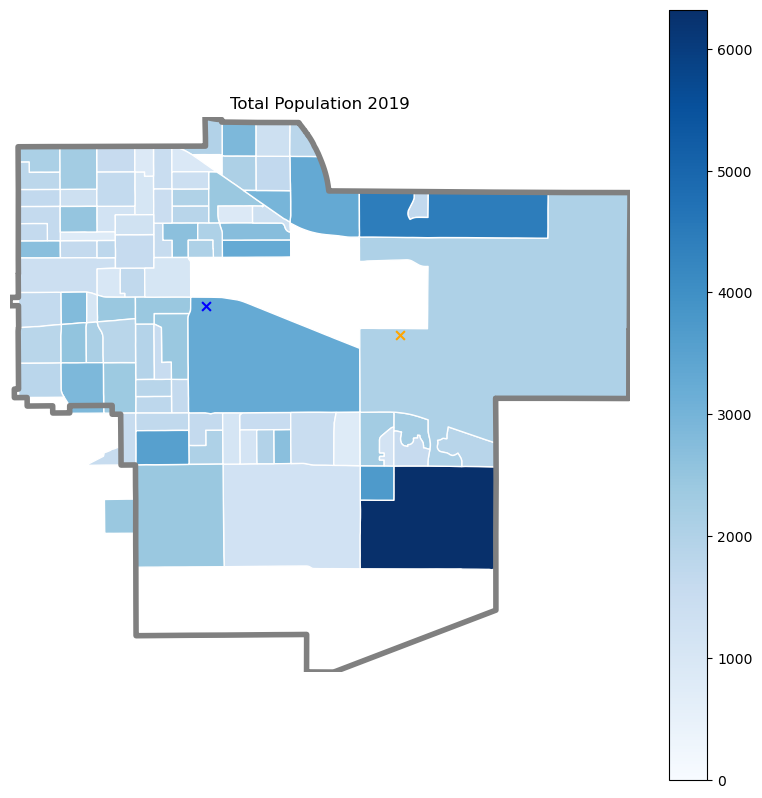

In [9]:
variable = 'Total Population 2019'
fig, ax = plt.subplots(1,figsize = (10,10))
SB_County_Block_Group_Employment.plot(column=variable,  ax = ax, cmap='Blues', edgecolor="white", legend=True, vmin=0)
BGwmc_gdf.plot(ax=ax, color='blue',markersize=40,marker = "x")
Warehouse_gdf.plot(ax=ax, color='orange',markersize=40, marker = "x")

Ontario_boundary.plot(ax=ax, facecolor="none", edgecolor="grey", lw=4)
ax.set_title(variable)
ax.set_axis_off()
#ctx.add_basemap(ax, crs=4326);
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.add_patch(stdellipse)
print(ax)